<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/bs_deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.5 MB/s eta 0:00:00


In [6]:
import deepxde as dde
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [10]:
import deepxde as dde
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define the Black-Scholes PDE
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return dy_t + 0.5 * sigma**2 * x[:, 0:1]**2 * dy_xx + r * x[:, 0:1] * dy_x - r * y

# Define the boundary and initial conditions
def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.maximum(x[:, 0:1] - K, 0)

# Normalize the input data
def normalize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# Analytical solution for a European call option
def analytical_solution(x):
    S, t = x[:, 0:1], x[:, 1:2]
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)

# Parameters
sigma = 0.2  # volatility
r = 0.05     # risk-free interest rate
K = 50       # strike price
T = 1.0      # time to maturity

# Geometry and time domain
geom = dde.geometry.Interval(0, 100)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary and initial conditions
bc = dde.DirichletBC(geomtime, func, boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

# Data
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160)

# Neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Model
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.092401 s

'compile' took 0.641179 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.24e-02, 1.31e+03, 3.77e+02]    [1.24e-02, 1.31e+03, 3.77e+02]    []  
1000      [4.53e+00, 2.76e+01, 3.21e+00]    [4.53e+00, 2.76e+01, 3.21e+00]    []  
2000      [6.41e-01, 1.10e+00, 4.13e-01]    [6.41e-01, 1.10e+00, 4.13e-01]    []  
3000      [1.16e-01, 6.79e-02, 2.81e-01]    [1.16e-01, 6.79e-02, 2.81e-01]    []  
4000      [1.71e-01, 1.36e-01, 2.77e-01]    [1.71e-01, 1.36e-01, 2.77e-01]    []  
5000      [6.11e-02, 6.85e-03, 2.39e-01]    [6.11e-02, 6.85e-03, 2.39e-01]    []  
6000      [6.71e-02, 1.12e-02, 2.43e-01]    [6.71e-02, 1.12e-02, 2.43e-01]    []  
7000      [3.81e-02, 1.05e-02, 2.00e-01]    [3.81e-02, 1.05e-02, 2.00e-01]    []  
8000      [1.36e-01, 1.61e-01, 2.76e-01]    [1.36e-01, 1.61e-01, 2.76e-01]    []  
9000      [4.55e-02, 4.84e-03, 2.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


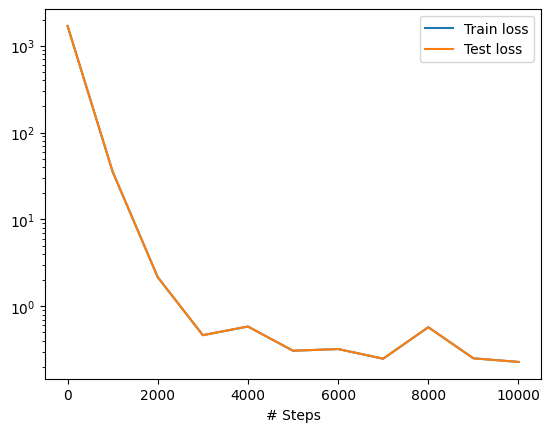

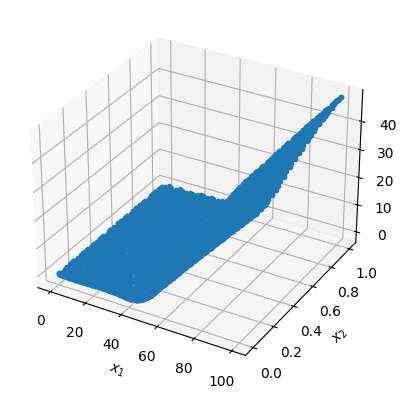

In [13]:
# Plot results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Relative L2 error: 0.10094016098042632


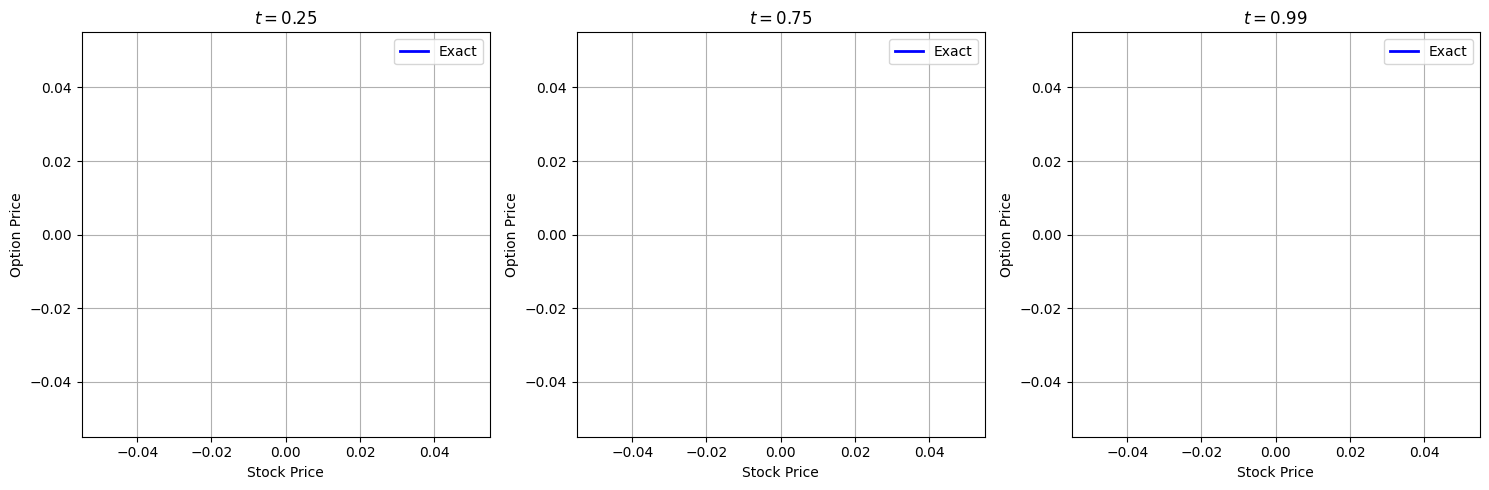

In [15]:
# Make predictions
X = geomtime.random_points(1000)
y_pred = model.predict(X)  # Use X instead of X_normalized

# Compare with analytical solution
y_true = analytical_solution(X)
error = np.linalg.norm(y_pred - y_true, 2) / np.linalg.norm(y_true, 2)
print("Relative L2 error:", error)

# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [0.25, 0.75, 0.99]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    X_slice = X[X[:, 1] == t_slice]
    y_pred_slice = model.predict(X_slice)  # Use X_slice instead of X_slice_normalized

    # Compute exact solution
    y_true_slice = analytical_solution(X_slice)

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(X_slice[:, 0], y_true_slice, 'b-', label='Exact', linewidth=2)
    #plt.plot(X_slice[:, 0], y_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("Stock Price")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [17]:
len(y_true)

1000